<a href="https://colab.research.google.com/github/parlad/AI_Agents/blob/main/Goal_Modify_ImageNet_to_find_the_opposite_spectr_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Okay, let's tackle this interesting goal. Directly modifying ImageNet itself isn't the usual approach. Instead, we'll use a model *pre-trained* on ImageNet to understand image content and then implement logic to find images representing an "opposite" concept based on the ImageNet class structure.

**Challenges and Considerations:**

1.  **Defining "Opposite":** This is subjective. "Cat" vs. "Dog" is intuitive. But what's the opposite of a "car"? A "bicycle"? A "tree"? A "pedestrian"? We need a way to define this relationship. Using the WordNet hierarchy, upon which ImageNet is based, is a common approach (e.g., finding sibling categories under a common parent). For simplicity in this example, we'll start with a manual mapping.
2.  **Full ImageNet Dataset:** The full ImageNet dataset is massive (~150GB compressed, >1TB uncompressed) and contains over 14 million images. Processing or searching this entire dataset directly in a standard notebook is impractical due to memory, storage, and computation time.
3.  **Image vs. Video:** ImageNet is primarily an *image* dataset. The request mentions "videos," but we'll focus on finding *images* representing the opposite concept using ImageNet's structure and models trained on it. Applying this to video would require video-specific models and datasets.
4.  **Implementation:** We will use a pre-trained Convolutional Neural Network (CNN) like ResNet, load necessary libraries (PyTorch, torchvision), define our "opposite" mapping, and demonstrate how to classify an input image and then find examples of its "opposite."

**Approach:**

1.  **Load a Pre-trained Model:** Use a model like ResNet50 trained on ImageNet.
2.  **Load ImageNet Labels:** Get the standard list of 1000 ImageNet class labels.
3.  **Define "Opposite" Mapping:** Create a dictionary mapping some source classes to desired target "opposite" classes.
4.  **Process Input Image:** Load an example image (e.g., a cat), preprocess it, and predict its class using the model.
5.  **Find Opposite Class(es):** Look up the predicted class in our mapping to find the target opposite class(es).
6.  **Retrieve Opposite Examples:** *Crucially*, since we likely don't have the full ImageNet locally, we'll simulate finding opposites by loading pre-selected example images of the target class. A real implementation on a server with the dataset would search the relevant class folders.

**Code for Notebook (using PyTorch):**

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


ResNet50 model loaded.
Labels downloaded.
Loaded 1000 ImageNet labels.

--- Processing Input Image: https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/640px-Cat03.jpg ---
Predicted Label: tiger cat (Index: 282, Confidence: 0.5572)


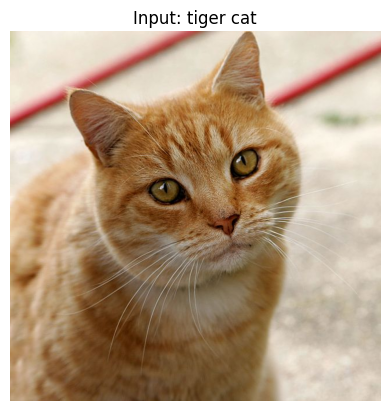

Found 'opposite' target labels: ['domestic dog', 'canine', 'dog']

--- Showing Example 'Opposite' Images ---
Showing example for: domestic dog
Error loading image from https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Short_coated_Border_Collie_18_months_old.jpg/640px-Short_coated_Border_Collie_18_months_old.jpg: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Short_coated_Border_Collie_18_months_old.jpg/640px-Short_coated_Border_Collie_18_months_old.jpg
Showing example for: canine


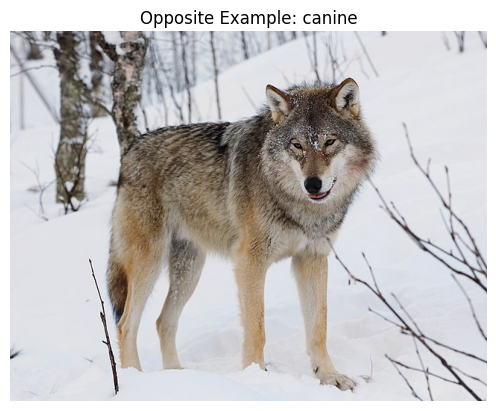

Showing example for: dog
Error loading image from https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Golden_Retriever_standing_frontal.jpg/640px-Golden_Retriever_standing_frontal.jpg: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Golden_Retriever_standing_frontal.jpg/640px-Golden_Retriever_standing_frontal.jpg

--- Processing Input Image: https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg/640px-2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg ---
Error loading image from https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg/640px-2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload

In [1]:
# --- Step 1: Setup and Imports ---
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Step 2: Configuration ---
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Step 3: Load Pre-trained Model ---
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()  # Set the model to evaluation mode
model.to(device)
print("ResNet50 model loaded.")

# --- Step 4: Load ImageNet Class Labels ---
# Download labels if not present
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
LABELS_PATH = "imagenet_simple_labels.json"

if not os.path.exists(LABELS_PATH):
    print("Downloading ImageNet labels...")
    response = requests.get(LABELS_URL)
    response.raise_for_status() # Raise an exception for bad status codes
    with open(LABELS_PATH, 'w') as f:
        f.write(response.text)
    print("Labels downloaded.")

# Load the labels
with open(LABELS_PATH) as f:
    labels = json.load(f)
print(f"Loaded {len(labels)} ImageNet labels.")

# --- Step 5: Define "Opposite" Mapping (Manual Example) ---
# This is the core subjective part. We map *human-readable labels*.
# You'll need to expand this based on your definition of "opposite".
# Keys are potential predicted labels (or parts of them), values are the desired opposite labels.
opposite_map = {
    # Animals
    "cat": ["dog", "domestic dog", "canine"], # If input is any cat, look for dogs
    "dog": ["cat", "tabby", "tiger cat", "Persian cat"], # If input is any dog, look for cats
    "lion": ["zebra", "gazelle", "antelope"], # Predator -> Prey
    "zebra": ["lion", "cheetah", "leopard"], # Prey -> Predator
    # Vehicles
    "car": ["bicycle", "motorcycle", "scooter"], # Motorized 4-wheel -> 2-wheel/manual
    "bicycle": ["car", "sports car", "minivan"], # Manual -> Motorized
    # Others
    "laptop": ["desktop computer", "monitor"],
    "keyboard": ["mouse"],
    "hot": ["cold", "ice", "snow"], # Conceptual (requires images tagged appropriately)
    "day": ["night", "moon", "stars"] # Conceptual
}

# Function to find relevant keys in the map
def find_opposite_targets(predicted_label):
    targets = []
    predicted_label_lower = predicted_label.lower()
    for key_term, target_labels in opposite_map.items():
        if key_term in predicted_label_lower:
            targets.extend(target_labels)
    return list(set(targets)) # Return unique targets

# --- Step 6: Image Preprocessing ---
# Standard ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Helper function to load image from URL
def load_image_from_url(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(response.raw).convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

# Helper function to display images
def show_image(image, title=""):
    # If it's a tensor, convert it back
    if isinstance(image, torch.Tensor):
        # Un-normalize (approximate) and convert to PIL
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
        image = transforms.ToPILImage()(image.cpu())

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Step 7: Process Input Image and Find Opposite ---

def predict_and_find_opposite(image_url):
    print(f"\n--- Processing Input Image: {image_url} ---")
    input_image = load_image_from_url(image_url)
    if input_image is None:
        return None, None

    # Preprocess the image
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # Create a mini-batch as expected by the model
    input_batch = input_batch.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get probabilities and predicted class
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top1_prob, top1_catid = torch.topk(probabilities, 1)
    predicted_index = top1_catid[0].item()
    predicted_label = labels[predicted_index]
    confidence = top1_prob[0].item()

    print(f"Predicted Label: {predicted_label} (Index: {predicted_index}, Confidence: {confidence:.4f})")
    show_image(input_image, f"Input: {predicted_label}")

    # Find opposite targets based on our map
    opposite_target_labels = find_opposite_targets(predicted_label)

    if not opposite_target_labels:
        print("No 'opposite' mapping found for this prediction.")
        return predicted_label, []
    else:
        print(f"Found 'opposite' target labels: {opposite_target_labels}")
        return predicted_label, opposite_target_labels

# --- Step 8: Simulate Finding Opposite Images ---
# In a real scenario with the dataset, you would search for images
# belonging to the `opposite_target_labels`.
# Here, we'll just use predefined example URLs for demonstration.

example_opposites_urls = {
    "dog": "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Golden_Retriever_standing_frontal.jpg/640px-Golden_Retriever_standing_frontal.jpg",
    "domestic dog": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Short_coated_Border_Collie_18_months_old.jpg/640px-Short_coated_Border_Collie_18_months_old.jpg",
    "canine": "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Eurasian_wolf_2.jpg/640px-Eurasian_wolf_2.jpg",
    "cat": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/640px-Cat_November_2010-1a.jpg",
    "tabby": "https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Brown_and_grey_tabby_cat_with_green_eyes-800x600.jpg/640px-Brown_and_grey_tabby_cat_with_green_eyes-800x600.jpg",
    "zebra": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Plains_Zebra_Equus_quagga.jpg/640px-Plains_Zebra_Equus_quagga.jpg",
    "lion": "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/640px-Lion_waiting_in_Namibia.jpg",
    "bicycle": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Left_side_of_Flying_Pigeon.jpg/640px-Left_side_of_Flying_Pigeon.jpg",
    "car": "https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Lamborghini_Aventador_LP700-4_Matte_Black.jpg/640px-Lamborghini_Aventador_LP700-4_Matte_Black.jpg",
    # Add more example URLs corresponding to your opposite_map values
}

def show_opposite_examples(target_labels):
    print("\n--- Showing Example 'Opposite' Images ---")
    found_examples = False
    for label in target_labels:
        label_lower = label.lower()
        if label_lower in example_opposites_urls:
            print(f"Showing example for: {label}")
            img = load_image_from_url(example_opposites_urls[label_lower])
            if img:
                show_image(img, f"Opposite Example: {label}")
                found_examples = True
        # else:
            # print(f"(No example URL defined for: {label})") # Optional message

    if not found_examples:
        print("Could not find any example images for the target opposite labels in our predefined list.")


# --- Step 9: Run Examples ---

# Example 1: Cat -> Dog
cat_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/640px-Cat03.jpg"
predicted, targets = predict_and_find_opposite(cat_url)
if targets:
    show_opposite_examples(targets)

# Example 2: Car -> Bicycle/Motorcycle
car_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg/640px-2019_Toyota_Corolla_Icon_Tech_HEV_CVT_1.8_Front.jpg"
predicted, targets = predict_and_find_opposite(car_url)
if targets:
    show_opposite_examples(targets)

# Example 3: Lion -> Zebra
lion_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/640px-Lion_waiting_in_Namibia.jpg"
predicted, targets = predict_and_find_opposite(lion_url)
if targets:
    show_opposite_examples(targets)

# Example 4: Unmapped item
keyboard_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Apple_Wireless_Keyboard_on_black_background.jpg/640px-Apple_Wireless_Keyboard_on_black_background.jpg"
predicted, targets = predict_and_find_opposite(keyboard_url)
# No opposite defined for 'keyboard' in our simple map, so it won't find specific targets
# We added "keyboard": ["mouse"] to the map, let's see if it works
if targets:
    show_opposite_examples(targets) # Need to add a mouse URL to example_opposites_urls

**Explanation:**

1.  **Setup:** Imports necessary libraries (PyTorch, TorchVision, PIL, requests, json, matplotlib, numpy, os). Sets the device to GPU if available.
2.  **Load Model:** Loads the ResNet50 model pre-trained on ImageNet. `model.eval()` is important as it disables dropout and batch normalization updates, suitable for inference.
3.  **Load Labels:** Downloads (if needed) and loads a simple JSON file mapping ImageNet's 1000 class indices to human-readable labels.
4.  **Define "Opposite" Mapping:** This `opposite_map` dictionary is where you define the core logic. It maps keywords found in predicted labels (keys) to a list of desired "opposite" labels (values). This is highly customizable and the most subjective part. The `find_opposite_targets` function checks if any part of the predicted label matches a key in the map.
5.  **Image Preprocessing:** Defines the standard transformations (resize, crop, convert to tensor, normalize) expected by the ResNet model.
6.  **Helper Functions:** `load_image_from_url` fetches an image, `show_image` displays it using Matplotlib (handling both PIL images and tensors).
7.  **Predict and Find Opposite:** The `predict_and_find_opposite` function takes an image URL, loads and preprocesses the image, runs it through the model, gets the top prediction, finds corresponding "opposite" targets using the map, and displays the input image and prediction.
8.  **Simulate Finding Opposite Images:** Since we don't have ImageNet locally, the `example_opposites_urls` dictionary stores URLs for *potential* opposite images. The `show_opposite_examples` function looks up the target labels in this dictionary and displays the corresponding example images.
9.  **Run Examples:** Demonstrates the process with different input images (cat, car, lion, keyboard).

**How to Improve/Extend:**

1.  **Better "Opposite" Definition:** Instead of a manual map, use the WordNet hierarchy. You could use libraries like `nltk` to:
    * Find the WordNet synset for the predicted class.
    * Find its parent synset(s) (hypernyms).
    * Find other children (hyponyms) of the same parent(s) – these are siblings.
    * Select siblings that are semantically distant or fit a defined "opposite" criterion (e.g., domestic animal vs. wild animal under the 'animal' parent). This is more complex but more robust.
2.  **Feature Vector Distance:** Instead of relying purely on labels, you could:
    * Get the feature vector for the input image (output of a layer before the final classification layer).
    * Calculate average feature vectors for different classes in ImageNet (requires processing at least the validation set once).
    * Define "opposite" as classes whose average feature vectors are *maximally distant* (e.g., using cosine distance) from the input image's class vector. This is computationally more intensive.
3.  **Using a Local Dataset:** If you have a subset of ImageNet (like the validation set, often ~50GB) stored locally and organized into class folders, you could modify `show_opposite_examples` to actually browse the folders corresponding to `target_labels` and pick random images from there.
4.  **Handling Ambiguity:** A single input might have multiple "opposites." The current code lists all found targets; you might want to prioritize or select just one.

This code provides a starting point for your goal within the constraints of a typical notebook environment, focusing on leveraging pre-trained models and class labels rather than modifying the dataset itself. Remember to install the necessary libraries (`pip install torch torchvision matplotlib requests Pillow`).

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://github.com/DoKu88/CNS-186-Project">https://github.com/DoKu88/CNS-186-Project</a></li>
  <li><a href="https://github.com/locua/art">https://github.com/locua/art</a></li>
  <li><a href="https://github.com/mmahdin/image-processing-multimedia-projects">https://github.com/mmahdin/image-processing-multimedia-projects</a></li>
  <li><a href="https://github.com/KiranR-max/SqueezeNet1.0">https://github.com/KiranR-max/SqueezeNet1.0</a></li>
  <li><a href="https://github.com/JacopoBulgarelli/DeepLearningPoli">https://github.com/JacopoBulgarelli/DeepLearningPoli</a></li>
  <li><a href="https://jishuzhan.net/article/1728209631706091521">https://jishuzhan.net/article/1728209631706091521</a></li>
  <li><a href="https://github.com/Frescope/VHL_GNN_v2">https://github.com/Frescope/VHL_GNN_v2</a></li>
  <li><a href="https://github.com/PacktPublishing/Python-Deep-Learning-Third-Edition">https://github.com/PacktPublishing/Python-Deep-Learning-Third-Edition</a></li>
  </ol>
</div>